[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


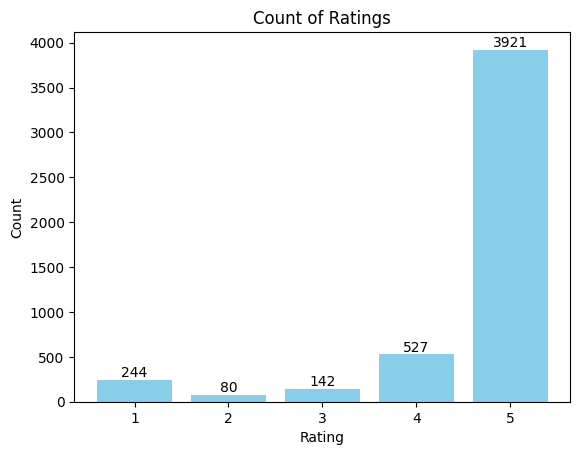

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import random

#Dataset Loading and Initial Exploration
df = pd.read_csv('/content/drive/MyDrive/1-amazon_reviews.csv')
df.head()
#Checking for Missing Values
missing_values = df.isnull()
#Count the number of missing values
missing_value_count = missing_values.sum()
print(missing_value_count)
#Revome missing values
df.dropna(subset=['reviewText'], inplace=True)
# Count occurrences of each rating
rating_counts = df['overall'].value_counts().sort_index()

# Create bar chart
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')


# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count of Ratings')

# Add x-axis labels
plt.xticks(rating_counts.index)

# Add labels to each bar
for i, count in enumerate(rating_counts.values):
    plt.text(rating_counts.index[i], count, str(count), ha='center', va='bottom')

# Show plot
plt.show()
# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Function to perform NER on text
def perform_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER function to DataFrame
df['ner_entities'] = df['reviewText'].apply(perform_ner)

# Print DataFrame with NER results
df.head()

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Handle special characters
    text = re.sub(r'\s+', ' ', text)

    # Tokenize the text into individual words
    words = word_tokenize(text)

    # Lemmatize words to their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a single string
    preprocessed_text = ' '.join(words)

    return preprocessed_text

# df is DataFrame with the 'reviewText' column
df['cleaned_reviewText'] = df['reviewText'].apply(preprocess_text)

# Function to perform NER and extract organization names
def extract_org_names(text):
    doc = nlp(text)
    org_names = [ent.text for ent in doc.ents if ent.label_ == 'ORG']
    return org_names

# Apply NER and organization name extraction function to DataFrame
df['org_names'] = df['reviewText'].apply(extract_org_names)

# Flatten the list of organization names
all_org_names = [name.lower() for sublist in df['org_names'] for name in sublist]

# Count occurrences of each organization name
org_name_counts = pd.Series(all_org_names).value_counts()

# Select top 5 most common organization names
top_5_org_names = org_name_counts.head(5)

# Create bar chart
plt.bar(top_5_org_names.index, top_5_org_names.values, color='skyblue')

# Add labels and title
plt.xlabel('Organization Name')
plt.ylabel('Count')
plt.title('Top 5 Most Mentioned Organizations')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

# Function to classify sentiment as positive, negative, or neutral
def classify_sentiment(sentiment):
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

# Function to perform sentiment analysis and count occurrences of each sentiment category
def count_sentiments(reviews):
    sentiments = reviews.apply(lambda text: classify_sentiment(TextBlob(text).sentiment.polarity))
    sentiment_counts = sentiments.value_counts()
    return sentiment_counts

# Initialize a dictionary to store sentiment counts for each organization
sentiment_counts_by_org = {}

# Iterate over the top 5 organization names
for org in top_5_org_names.index:
    # Filter the DataFrame to get reviews mentioning the current organization name
    org_reviews = df[df['reviewText'].str.contains(org, case=False)]['reviewText']
    # Count occurrences of each sentiment category in the reviews for the organization
    sentiment_counts = count_sentiments(org_reviews)
    sentiment_counts_by_org[org] = sentiment_counts

# Display the sentiment counts for each organization
for org, sentiment_counts in sentiment_counts_by_org.items():
    print(f"Organization: {org}")
    print(f"Positive Reviews: {sentiment_counts.get('positive', 0)}")
    print(f"Negative Reviews: {sentiment_counts.get('negative', 0)}")
    print(f"Neutral Reviews: {sentiment_counts.get('neutral', 0)}")
    print()

